# Preprocess Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv("resources/stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


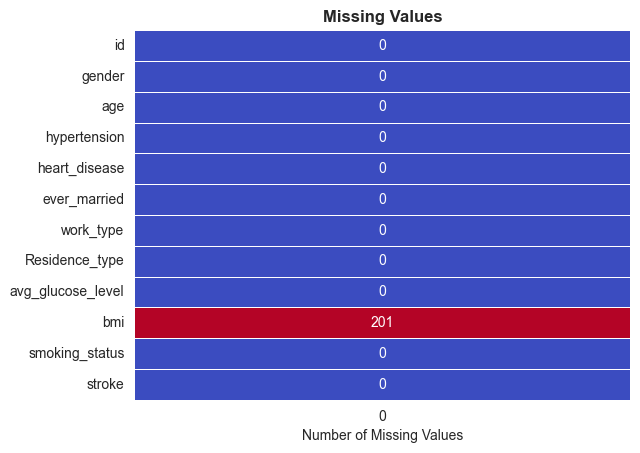

In [5]:
plt.title('Missing Values',fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='coolwarm', linewidths=0.5, cbar=False)
ax.set_xlabel('Number of Missing Values')
plt.show()

## Drop 'id' column

In [6]:
df = df.drop(['id'], axis=1)

## Fill missing values

In [7]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

Text(0.5, 1.0, 'Stroke')

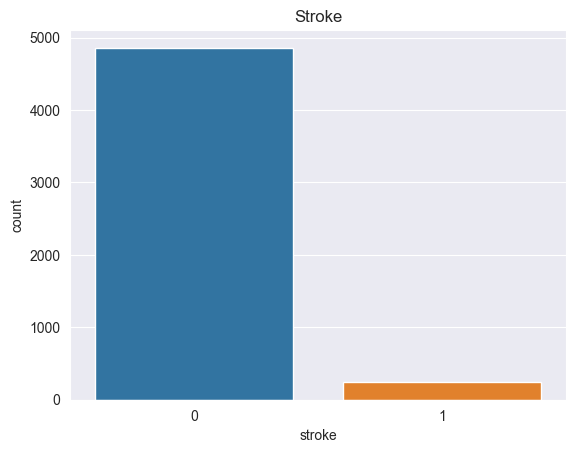

In [8]:
sns.countplot(data=df, x="stroke")
plt.title('Stroke')

# Look at the Data

In [9]:
round (df.describe(exclude = 'object'), 2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,5110.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.70,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.80,0.00
50%,45.00,0.0,0.00,91.88,28.40,0.00
75%,61.00,0.0,0.00,114.09,32.80,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00


In [10]:
round (df.describe(exclude = ['float', 'int64']), 2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


# Numeric Variable Distribution

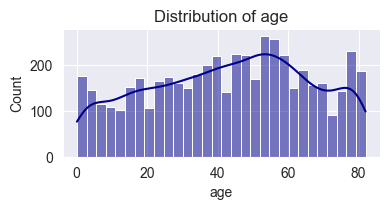

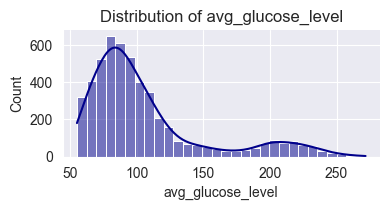

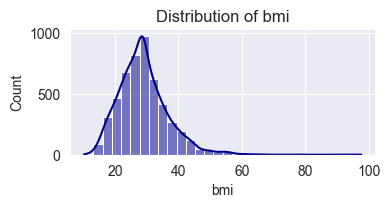

In [11]:

for col in df[['age','avg_glucose_level', 'bmi' ]].columns:
    sns.displot(df[col], bins=30, kde=True, color='darkblue', height=2, aspect=2).set(xlabel=col,title=f'Distribution of {col}')

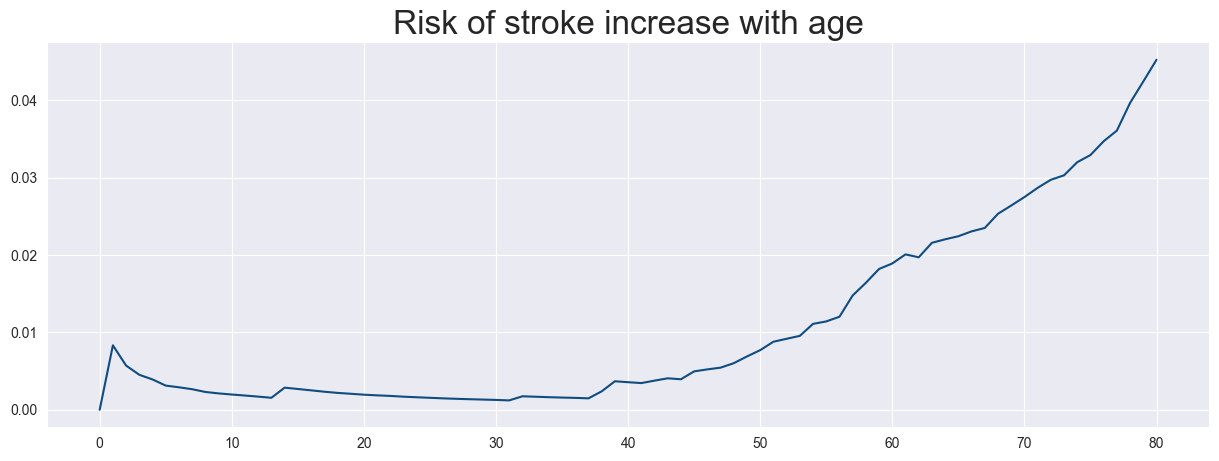

In [12]:
rate = []
ages = df['age'].astype(int)
for i in range(ages.min() + 1, ages.max()):
    rate.append((df[df['age'] < i]['stroke'].sum() / len(df[df['age'] < i]['stroke'])))
    
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(data=rate,color='#0f4c81', ax = ax).set_title("Risk of stroke increase with age",fontsize=24)
plt.show()

# Model preparation

In [14]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

def encode_labels(df, labels, encoder):
    for label in labels:
        df[label] = encoder.fit_transform(df[label], df['stroke'])


labels_to_encode = ['gender', 'ever_married', 'Residence_type', 'work_type', 'smoking_status']
encode_labels(df, labels_to_encode, TargetEncoder())

In [15]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0.051064,67.0,0,1,0.065613,0.050940,0.052003,228.69,36.600000,0.079096,1
1,0.047094,61.0,0,0,0.065613,0.079365,0.045346,202.21,28.893237,0.047569,1
2,0.051064,80.0,0,1,0.065613,0.050940,0.045346,105.92,32.500000,0.047569,1
3,0.047094,49.0,0,0,0.065613,0.050940,0.052003,171.23,34.400000,0.053232,1
4,0.047094,79.0,1,0,0.065613,0.079365,0.045346,174.12,24.000000,0.047569,1


# Correlations 

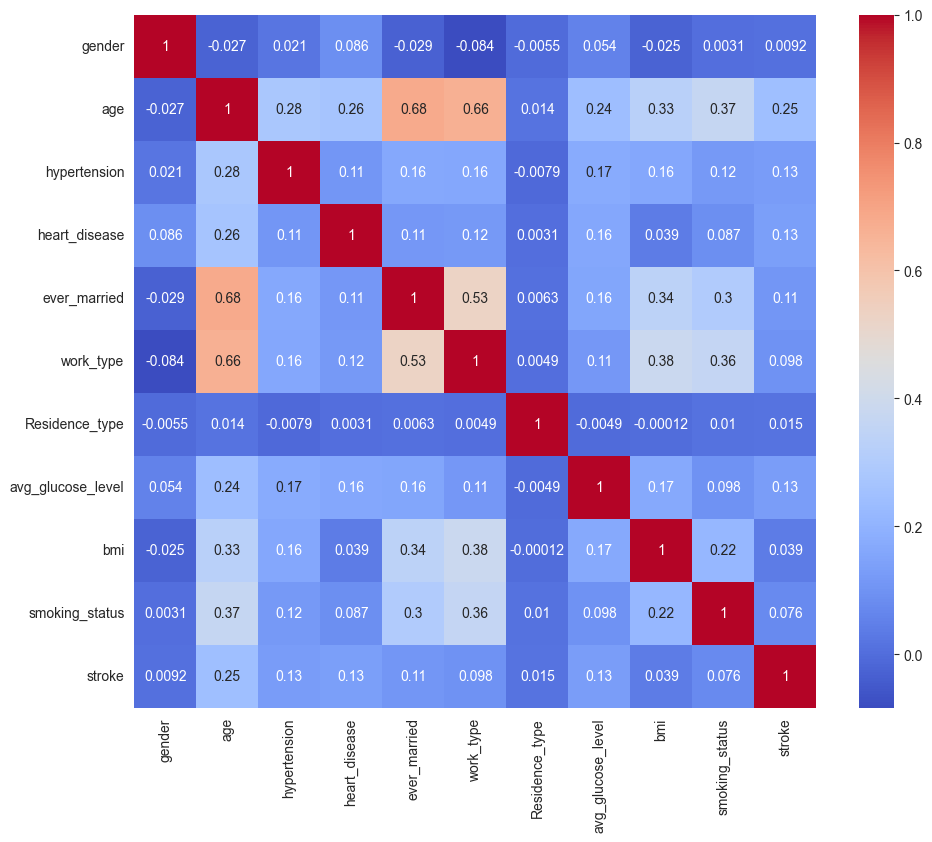

In [16]:
corr = df.corr()
plt.figure(figsize=(11, 9))
ax = sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.xticks(rotation=90)
plt.show()

## Split dataset

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(['stroke'], axis=1)
y = df['stroke']

## Balance dataset

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [19]:
oversampler = SMOTE(sampling_strategy = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_init = X_train
y_train_init = y_train

X_train, y_train = oversampler.fit_resample(X_train, y_train)

<Axes: xlabel='stroke', ylabel='count'>

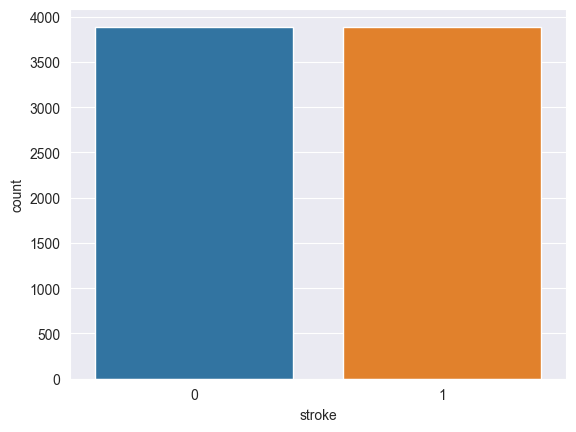

In [20]:
sns.countplot(x=y_train)

# Build models

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [22]:
def display_confution_matrix(model_name, y_test, y_pred):
    plt.title(model_name)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='coolwarm', cbar=False,
        yticklabels=['Actual non-stroke', 'Actual Stroke'], xticklabels=['Predicted non-stroke', 'Predicted stroke'])
    plt.show()
    
def display_ROC_curve(model_name, model, X_test, y_test):
    y_pred_p = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_p)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC ({model_name}) = ' + str(round(roc_auc, 2)))
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC curve plot ({model_name})')
    plt.show()

In [23]:
def test_models(X_train, y_train, X_test, y_test, models):
    model_scores = []
    
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    for model_name, model in models:
        model.fit(scaled_X_train, y_train)
        y_pred = model.predict(scaled_X_test)
        cm = confusion_matrix(y_test, y_pred)
        model_scores.append((model_name, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

        display_confution_matrix(model_name, y_test, y_pred)

        display_ROC_curve(model_name, model, scaled_X_test, y_test)
        
        print(classification_report(y_test, y_pred))

    return model_scores

In [24]:
models = [('KNearest Neighbor Classifier', KNeighborsClassifier()),
          ('Decision Tree Classifier', DecisionTreeClassifier()),
          ('Ada Boost Classifier', AdaBoostClassifier()),
          ('SVM Classifier', SVC(probability=True))]

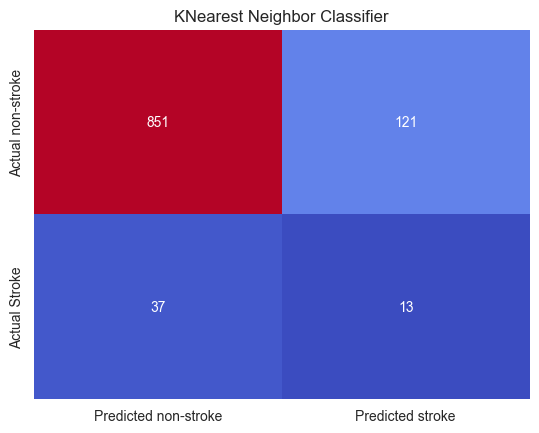

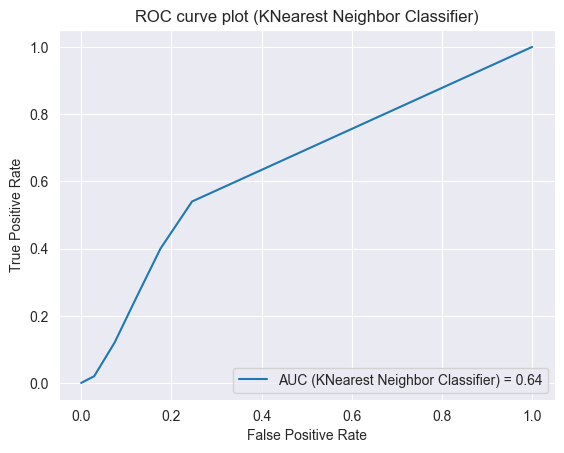

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       972
           1       0.10      0.26      0.14        50

    accuracy                           0.85      1022
   macro avg       0.53      0.57      0.53      1022
weighted avg       0.92      0.85      0.88      1022



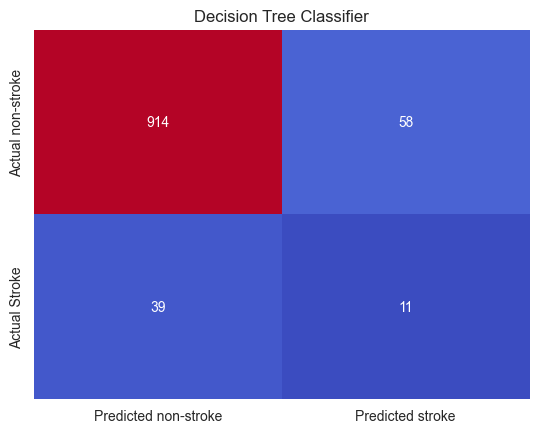

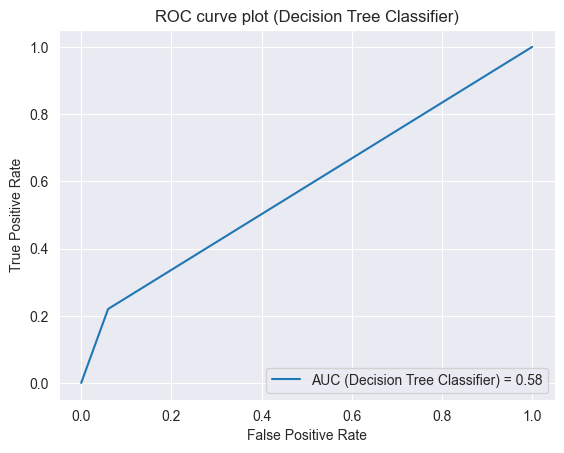

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.16      0.22      0.18        50

    accuracy                           0.91      1022
   macro avg       0.56      0.58      0.57      1022
weighted avg       0.92      0.91      0.91      1022



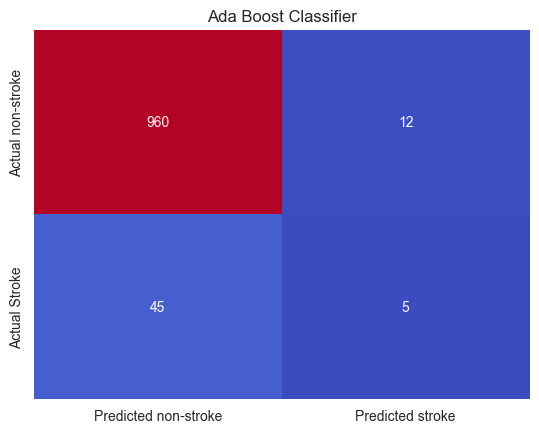

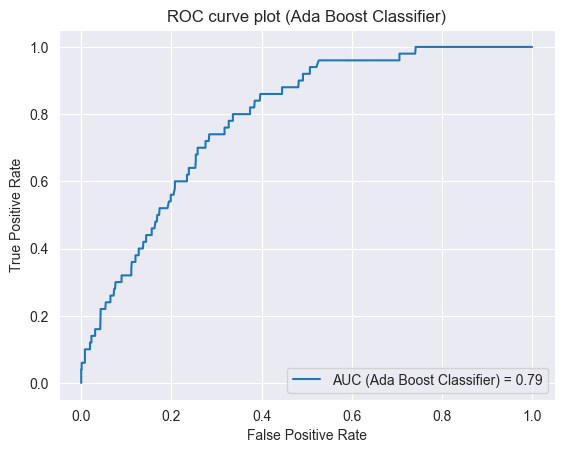

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       972
           1       0.29      0.10      0.15        50

    accuracy                           0.94      1022
   macro avg       0.62      0.54      0.56      1022
weighted avg       0.92      0.94      0.93      1022



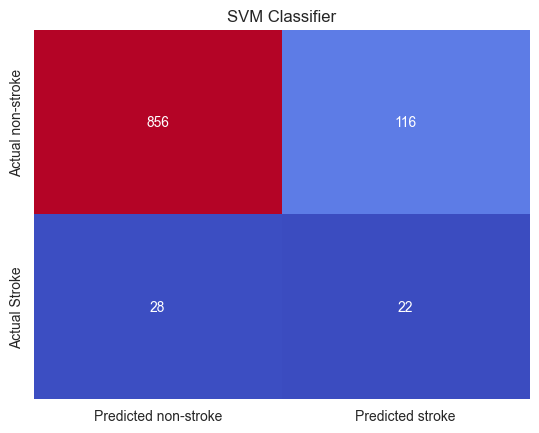

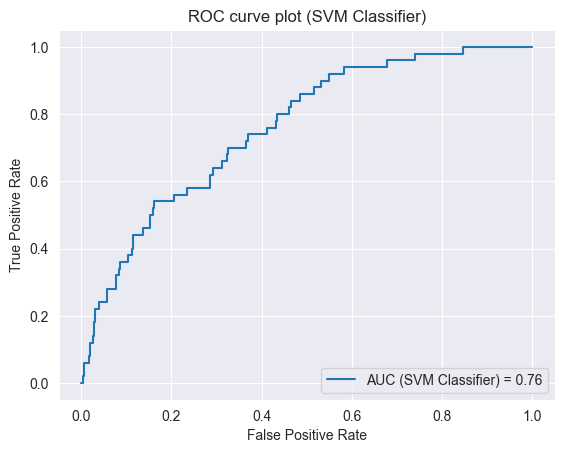

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       972
           1       0.16      0.44      0.23        50

    accuracy                           0.86      1022
   macro avg       0.56      0.66      0.58      1022
weighted avg       0.93      0.86      0.89      1022



In [25]:
model_scores = test_models(X_train, y_train, X_test, y_test, models)

In [26]:
def cross_validate(X, y, models, scoring='recall'):
    for name, model in models:
        pipeline = Pipeline(steps = [('smote', SMOTE(random_state=11)),
                                     ('scaler', StandardScaler()),
                                     ('classifier', model)])

        cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
        print(f'Model name: {name}')
        print(f"Cross Validation Score ({scoring}): ",'{0:.2%}'.format(cross_val_score(pipeline, X, y, cv = cv, scoring = scoring, n_jobs = -1).mean()))



In [ ]:
# cross_validate(X, y, models)

# Tune models

In [27]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


def tune_model(model, params, X_train, y_train, scoring):
    cv =  RepeatedStratifiedKFold(n_splits = 2, n_repeats = 3, random_state = 42)
    
    pipeline = Pipeline(steps = [('smote', SMOTE(random_state=11)),
                                 ('scaler', StandardScaler()),
                                 ('clf', model)])
    
    grid = GridSearchCV(pipeline, param_grid=params, scoring=scoring, cv=5, n_jobs = -1, verbose = 3)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_score_)
    

In [35]:
knn_params = {'clf__n_neighbors' : [5, 7, 9, 11, 13, 15],
              'clf__weights' : ['uniform', 'distance'],
              'clf__metric' : ['minkowski', 'euclidean', 'manhattan'],
              'clf__leaf_size' : [10, 15, 20, 25, 30, 35, 40, 45, 50]}

tune_model(KNeighborsClassifier(),knn_params, X_train_init, y_train_init, 'f1')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'clf__leaf_size': 10, 'clf__metric': 'minkowski', 'clf__n_neighbors': 15, 'clf__weights': 'uniform'}
0.15896555419997035


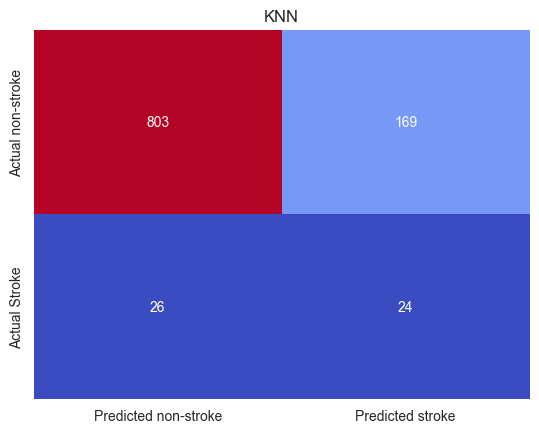

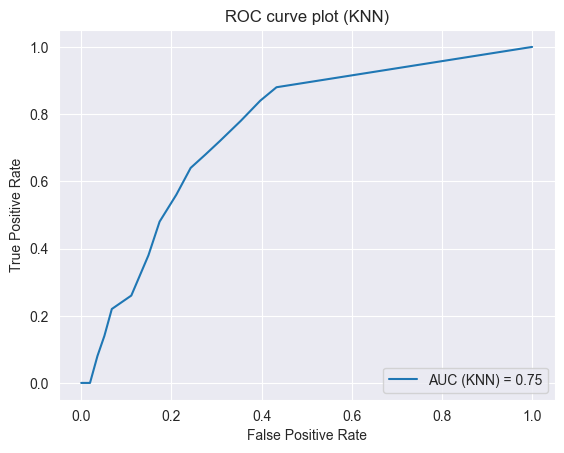

              precision    recall  f1-score   support

           0       0.97      0.83      0.89       972
           1       0.12      0.48      0.20        50

    accuracy                           0.81      1022
   macro avg       0.55      0.65      0.54      1022
weighted avg       0.93      0.81      0.86      1022



[('KNN', 0.8091976516634051, 0.19753086419753085)]

In [36]:
model = KNeighborsClassifier(leaf_size = 10, n_neighbors = 15, weights = 'uniform', metric = 'minkowski')

test_models(X_train, y_train, X_test, y_test, [('KNN', model)])

In [28]:
svm_params = {'clf__C': [0.1, 1, 10, 100, 1000],
              'clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'clf__kernel': ['rbf', 'sigmoid']}
tune_model(SVC(), svm_params, X_train_init, y_train_init, 'f1')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.2043553893154101


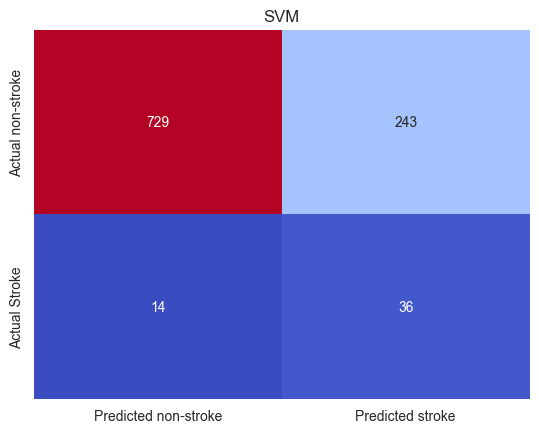

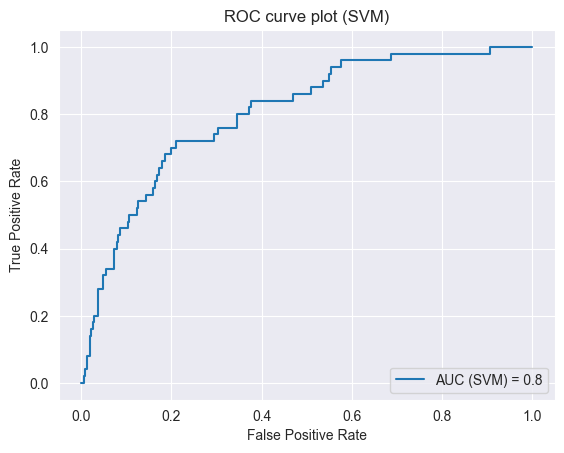

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       972
           1       0.13      0.72      0.22        50

    accuracy                           0.75      1022
   macro avg       0.56      0.73      0.53      1022
weighted avg       0.94      0.75      0.82      1022



[('SVM', 0.7485322896281801, 0.2188449848024316)]

In [29]:
model = SVC(C = 10, gamma = 0.001, kernel = 'rbf', probability=True)

test_models(X_train, y_train, X_test, y_test, [('SVM', model)])

In [30]:
# cross_validate(X, y, [('SVM', model)])

In [31]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression

adaboost_params = {'clf__n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
                   'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                   'clf__algorithm': ['SAMME', 'SAMME.R'],
                   'clf__estimator': [DecisionTreeClassifier(), ExtraTreeClassifier(), LogisticRegression()]}
tune_model(AdaBoostClassifier(), adaboost_params, X_train_init, y_train_init, 'f1')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
{'clf__algorithm': 'SAMME.R', 'clf__estimator': LogisticRegression(), 'clf__learning_rate': 1.0, 'clf__n_estimators': 20}
0.20607423779107564


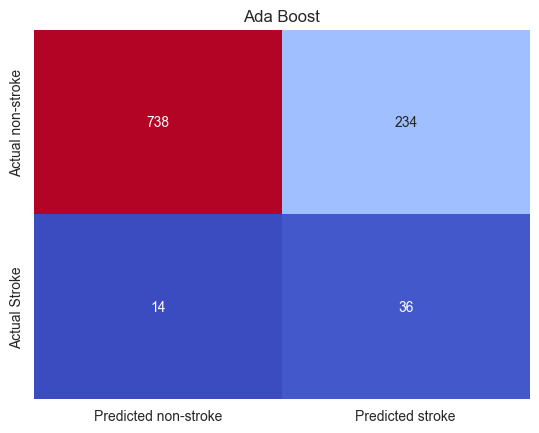

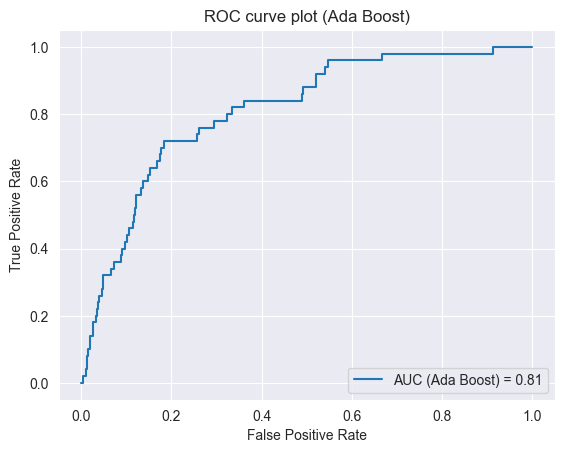

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       972
           1       0.13      0.72      0.23        50

    accuracy                           0.76      1022
   macro avg       0.56      0.74      0.54      1022
weighted avg       0.94      0.76      0.83      1022



[('Ada Boost', 0.7573385518590998, 0.22500000000000003)]

In [32]:
model = AdaBoostClassifier(estimator = LogisticRegression(), n_estimators = 20, learning_rate = 1.0, algorithm = 'SAMME.R')

test_models(X_train, y_train, X_test, y_test, [('Ada Boost', model)])

In [33]:
tune_model(AdaBoostClassifier(), adaboost_params, X_train_init, y_train_init, 'recall')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
{'clf__algorithm': 'SAMME', 'clf__estimator': LogisticRegression(), 'clf__learning_rate': 0.0001, 'clf__n_estimators': 2}
0.7737179487179487


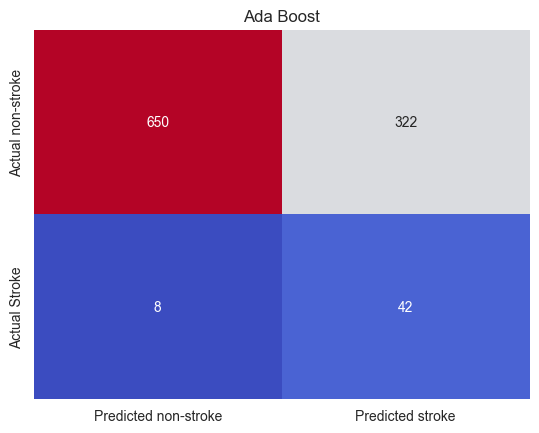

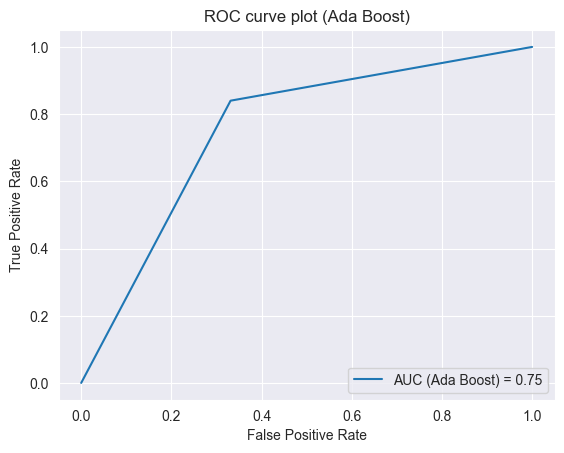

              precision    recall  f1-score   support

           0       0.99      0.67      0.80       972
           1       0.12      0.84      0.20        50

    accuracy                           0.68      1022
   macro avg       0.55      0.75      0.50      1022
weighted avg       0.95      0.68      0.77      1022



[('Ada Boost', 0.6771037181996086, 0.2028985507246377)]

In [34]:
model = AdaBoostClassifier(estimator = LogisticRegression(), n_estimators = 2, learning_rate = 0.0001, algorithm = 'SAMME')

test_models(X_train, y_train, X_test, y_test, [('Ada Boost', model)])

In [38]:
dt_params = {
    'clf__max_depth': [2, 3, 5, 10, 20],
    'clf__min_samples_leaf': [5, 10, 20, 50, 100],
    'clf__criterion': ["gini", "entropy"]
}
tune_model(DecisionTreeClassifier(), dt_params, X_train_init, y_train_init, 'f1')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 5}
0.1863233059587775


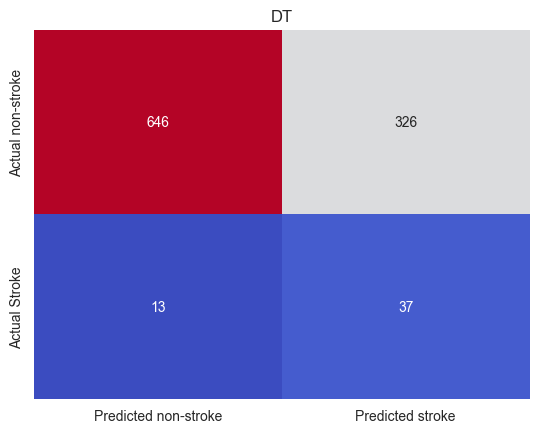

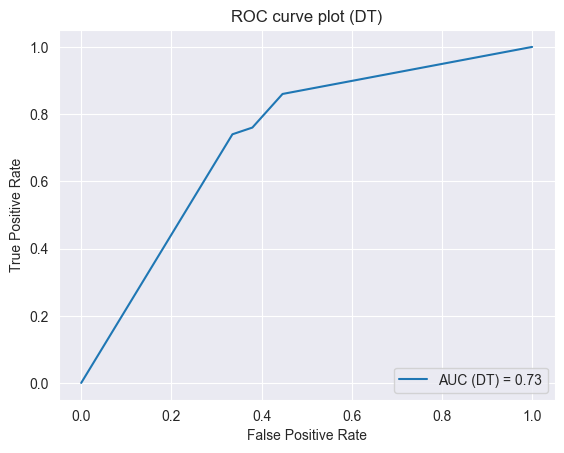

              precision    recall  f1-score   support

           0       0.98      0.66      0.79       972
           1       0.10      0.74      0.18        50

    accuracy                           0.67      1022
   macro avg       0.54      0.70      0.49      1022
weighted avg       0.94      0.67      0.76      1022



[('DT', 0.6682974559686888, 0.1791767554479419)]

In [39]:
model = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 5)

test_models(X_train, y_train, X_test, y_test, [('DT', model)])